# Part 3 - Predictive Modeling

What factors are the best predictors for rider retention?

## 1. Load, Clean, Explore Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split

### Load Data

In [2]:
#load json data
filepath = '../data/ultimate_data_challenge.json'

with open(filepath, "r") as f:
    data = json.load(f)

data[0]

{'city': "King's Landing",
 'trips_in_first_30_days': 4,
 'signup_date': '2014-01-25',
 'avg_rating_of_driver': 4.7,
 'avg_surge': 1.1,
 'last_trip_date': '2014-06-17',
 'phone': 'iPhone',
 'surge_pct': 15.4,
 'ultimate_black_user': True,
 'weekday_pct': 46.2,
 'avg_dist': 3.67,
 'avg_rating_by_driver': 5.0}

### Explore Data Structure / Clean

In [3]:
riders = pd.json_normalize(data)

riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
#look at dataframe info
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We have some missing data under avg_rating_of_driver, phone, and avg_rating_by_driver. I could see all of these being imporant factors in a retention model so we'll need to be intentional with how we address those missing records.

Column 1 and 5 should be updated to date types.

There is no target variable for retention. We can add this at some point. The description said this data was pulled 'several' months after January 2014 but we'll look at the 'last trip' measure and see if we can use that to estimate the date of the data run. This means we'll flag a rider as "retained" if they have had a ride in April 2014.

First let's look some more at the numerical variables.

In [5]:
riders.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


There are some definite outliers there in first 30 day trips, avg surge, surge %, and average distance - visual look:

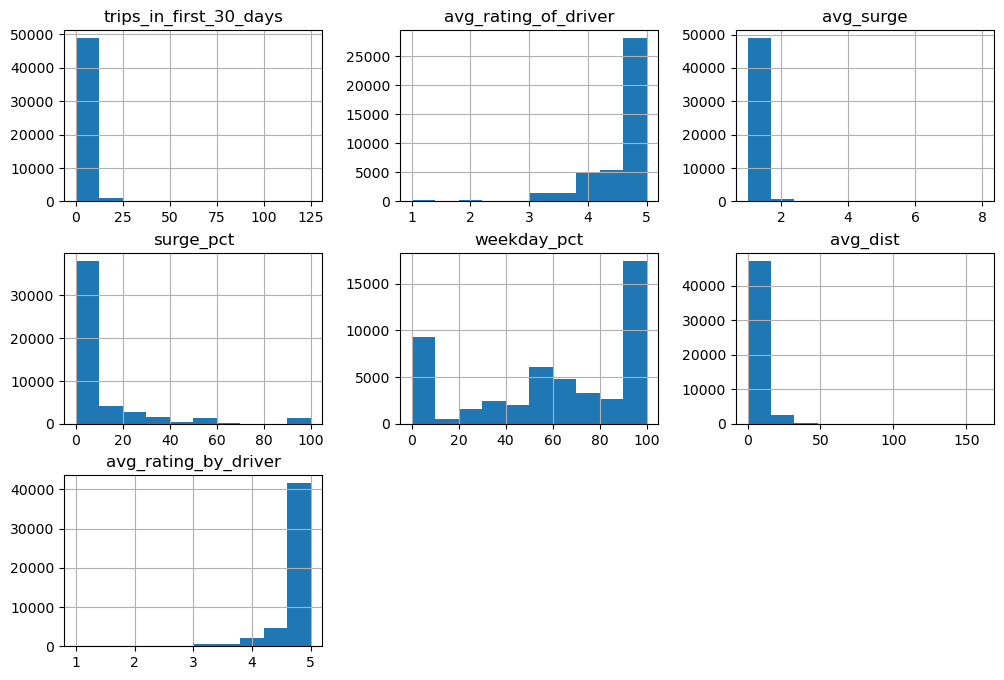

In [6]:
riders.hist(figsize=(12,8))

plt.show()

### Review Detail on Potential Outliers

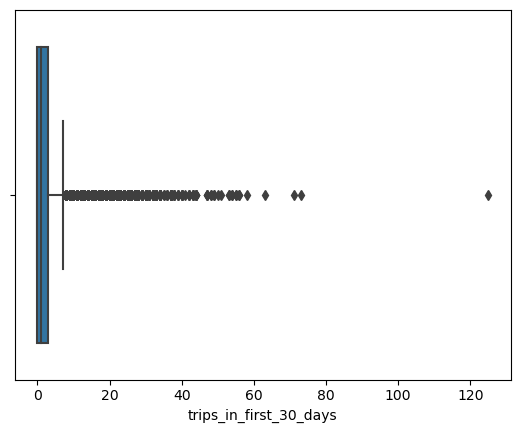

In [7]:
#rider is first 30 days boxplot
sns.boxplot(data=riders, x='trips_in_first_30_days')

plt.show()

In the boxplot sense, we see a lot of outliers with such a condensed IQR. Without being able to see the full ride details or talk with a business export, I could justify up to 60 if someone is commuting in and out of the city for 30 days straight. Let's check those details.

In [8]:
#Trips in First 30 Days details
riders.loc[riders.trips_in_first_30_days > 60]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
99,Astapor,73,2014-01-27,4.9,1.00,2014-03-05,Android,0.0,True,89.7,2.86,4.9
3030,Winterfell,71,2014-01-06,4.9,1.06,2014-06-28,iPhone,2.9,True,85.9,2.32,4.8
18514,King's Landing,125,2014-01-02,5.0,1.12,2014-06-30,iPhone,14.4,True,72.0,2.02,4.8
29070,Astapor,63,2014-01-10,4.0,1.07,2014-06-29,iPhone,7.3,True,83.3,1.45,4.6


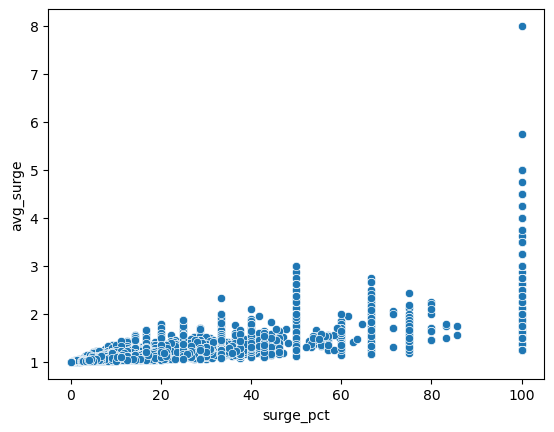

In [9]:
#avg surge and #surge_pct should relate, so let's look at those together
sns.scatterplot(data=riders, x='surge_pct', y='avg_surge')

plt.show()

Visually it looks like there is atleast one instance where surge_pct is > 0, but avg_surge is still 1. Let's look at that:

In [10]:
riders.loc[(riders.surge_pct>0) & (riders.avg_surge ==1)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
96,Winterfell,11,2014-01-26,4.1,1.0,2014-07-01,iPhone,1.9,True,76.9,4.89,4.6
1385,King's Landing,11,2014-01-02,5.0,1.0,2014-06-22,iPhone,1.9,True,61.1,1.78,4.8
3584,Astapor,5,2014-01-30,4.8,1.0,2014-06-28,iPhone,2.0,True,92.0,2.18,4.7
4726,Winterfell,11,2014-01-23,4.9,1.0,2014-06-28,iPhone,0.9,True,66.4,2.34,4.7
4847,Winterfell,18,2014-01-06,3.9,1.0,2014-06-30,iPhone,1.5,True,81.8,3.47,4.9


In [11]:
#check for the opposite effect
riders.loc[(riders.surge_pct==0) & (riders.avg_surge >1)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver


These records don't make sense to me -> if a user has some surge their avg surge should be greater than 1. I'll likely drop these. But there are none with a surge > 1 and 0 surge_pct which is good.

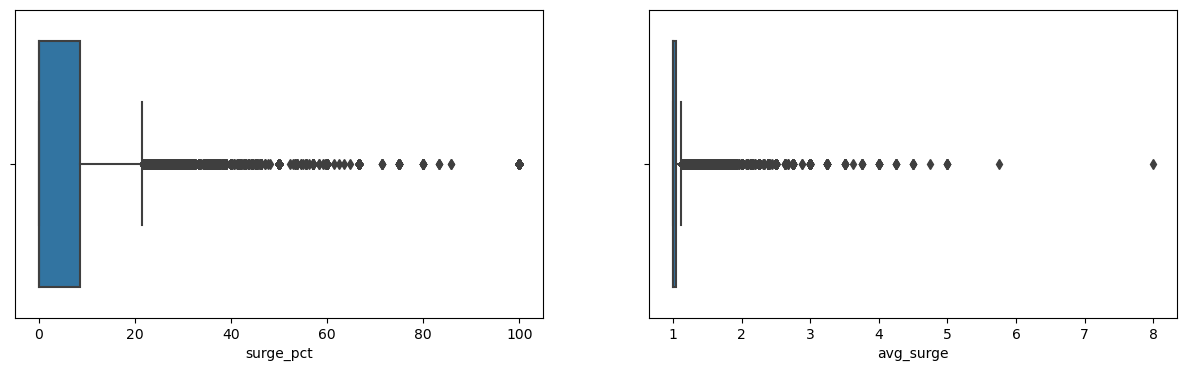

In [12]:
#view surge_pct & avg_surge together
fig, ax = plt.subplots(1, 2, figsize=(15,4))

sns.boxplot(ax=ax[0], data=riders, x='surge_pct')
sns.boxplot(ax=ax[1], data=riders, x='avg_surge')

plt.show()

I would say the 100% and 8 avg surge are big outliers. View those details.

In [13]:
riders.loc[(riders.surge_pct == 100)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
28,Winterfell,0,2014-01-19,NaN,1.50,2014-06-08,iPhone,100.0,False,0.0,5.97,5.0
32,Winterfell,1,2014-01-05,4.0,2.00,2014-06-10,iPhone,100.0,False,100.0,10.01,5.0
34,Astapor,1,2014-01-16,NaN,1.25,2014-01-17,Android,100.0,False,100.0,4.12,5.0
42,Winterfell,1,2014-01-25,4.0,1.50,2014-01-26,Android,100.0,False,0.0,5.72,5.0
47,Winterfell,1,2014-01-18,5.0,1.25,2014-01-19,iPhone,100.0,False,0.0,3.61,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49891,Astapor,0,2014-01-06,NaN,1.50,2014-03-30,iPhone,100.0,False,0.0,1.07,3.0
49894,Winterfell,0,2014-01-11,5.0,1.25,2014-02-21,iPhone,100.0,False,100.0,5.18,5.0
49928,Astapor,1,2014-01-04,5.0,2.00,2014-01-11,iPhone,100.0,False,100.0,0.58,5.0
49974,Winterfell,1,2014-01-05,5.0,2.00,2014-01-18,iPhone,100.0,False,100.0,4.63,5.0


1,416 rows is more than 2% of the overall data. This makes me think it's possible to only use during surge times. Which would make sense especially if they have limited trips overall. How about avg surge?

In [14]:
riders.loc[(riders.avg_surge >= 5)]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
2817,Winterfell,0,2014-01-02,5.0,5.00,2014-02-05,iPhone,100.0,False,100.0,3.18,5.0
13861,Winterfell,1,2014-01-01,1.0,8.00,2014-01-01,iPhone,100.0,False,100.0,5.77,5.0
19191,Winterfell,1,2014-01-10,5.0,5.00,2014-01-11,Android,100.0,False,100.0,3.37,5.0
21894,Winterfell,1,2014-01-10,NaN,5.00,2014-01-11,Android,100.0,False,100.0,2.46,4.0
30477,Winterfell,1,2014-01-01,5.0,5.75,2014-01-01,iPhone,100.0,False,100.0,1.98,5.0
47052,Winterfell,1,2014-01-09,NaN,5.00,2014-01-11,Android,100.0,False,100.0,2.96,5.0
49383,Winterfell,1,2014-01-10,NaN,5.00,2014-01-11,iPhone,100.0,False,100.0,2.40,5.0


It's hard to know if these high levels are realistic. But some googling of what Uber does makes it seem like a possibility these are realistic surge numbers.

Last one: avg_dist

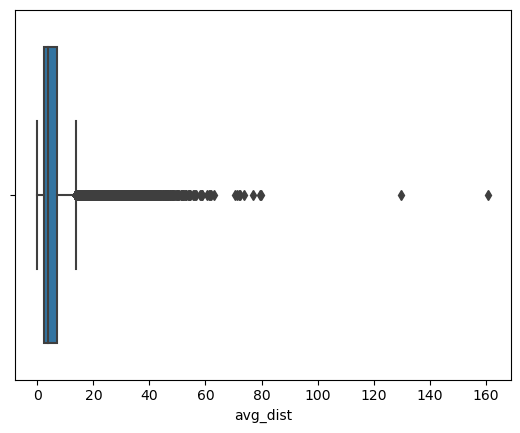

In [15]:
#rider is first 30 days boxplot
sns.boxplot(data=riders, x='avg_dist')

plt.show()

In [16]:
# the furthest two definitely jump out
riders.loc[riders.avg_dist >= 60]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
534,King's Landing,0,2014-01-04,NaN,1.0,2014-03-09,None,0.0,False,0.0,129.89,5.0
799,Astapor,0,2014-01-28,5.0,1.0,2014-05-15,Android,0.0,False,100.0,60.58,5.0
1302,Winterfell,1,2014-01-30,5.0,1.0,2014-01-30,iPhone,0.0,False,100.0,79.69,5.0
1493,Astapor,1,2014-01-26,5.0,1.0,2014-01-27,iPhone,0.0,False,100.0,72.08,5.0
8110,Winterfell,1,2014-01-18,5.0,1.0,2014-01-18,Android,0.0,True,0.0,62.14,5.0
18673,King's Landing,1,2014-01-23,NaN,1.0,2014-02-07,iPhone,0.0,True,100.0,61.45,5.0
18824,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,63.15,5.0
19197,Astapor,2,2014-01-17,4.7,1.0,2014-05-14,iPhone,0.0,True,100.0,71.38,5.0
20701,Astapor,0,2014-01-25,NaN,1.0,2014-06-26,Android,0.0,False,100.0,160.96,NaN
22096,Astapor,0,2014-01-17,NaN,1.0,2014-05-01,iPhone,0.0,True,100.0,72.20,5.0


Similar to the other metrics, it's impossible to tell if these are incorrect.

### Date Review Observations

Just because we don't know if data is just plain incorrect, doesn't mean we can't address it. I want to try to find a balance that removes outliers that will mess up the model, but still allow data that makes some business sense. So for cleanup I will:
- Drop 1st 30 day trips > 60
- Drop records with a surge_pct > 0 but avg_surge==1
- Drop avg_surg >= 5 to allow for users that run only during surge times, but get rid of some of the more extreme values
- Drop avg_g distance >= 60. That is still pretty high so it allows for those that do longer trips (maybe for travel) but removes some noise and there appears to be a jump from about 60 up to 70-75 in average distance.

### Implement Changes

In [17]:
rider_df = riders.copy() #create copy to adjust

#create mask
mask = rider_df.trips_in_first_30_days>60

#drop 30 day trips > 60
rider_df = rider_df[~mask] #only values not in mas

In [18]:
#drop surge records with avg_surg==1 but a surge % > 0

#create mask
mask1 = (rider_df.surge_pct>0) & (rider_df.avg_surge==1)

rider_df = rider_df[~mask1] #only save values that aren't in mask

In [19]:
#drop avg_surg >= 5

#create mask
mask2 = rider_df.avg_surge>=5

rider_df = rider_df[~mask2]

In [21]:
#drop avg_dist >= 60

#create mask
mask3 = rider_df.avg_dist>=60

rider_df = rider_df[~mask3]

In [22]:
#view new shape
rider_df.shape

(49929, 12)

### Update Date Types